In [1]:
import matplotlib.pyplot as plt 
import torch
import torchvision
from torch import nn

from torch import nn
from torchvision import transforms

import os
from torchvision import datasets, transforms
from torchvision.transforms import v2
from torch.utils.data import DataLoader

import warnings
import gc
warnings. filterwarnings("ignore")

import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix 
from torchmetrics import ConfusionMatrix

device = "cuda" if torch.cuda.is_available() else "cpu"
device

/opt/conda/lib/python3.10/site-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/v2/__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https:/

'cuda'

In [2]:
indir = '/kaggle/input/kvasir-dataset-for-classification-and-segmentation/kvasir-dataset/kvasir-dataset'

In [3]:
def analysis(model, test_dataloader, name, history):
    def display_confusion_matrix_seaborn(model, testing_dataloader):
        nb_classes = 8
        confusion_matrix = np.zeros((nb_classes, nb_classes))
        with torch.no_grad():
            for i, (inputs, classes) in enumerate(test_dataloader):
                inputs = inputs.to(device)
                classes = classes.to(device)
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                for t, p in zip(classes.view(-1), preds.view(-1)):
                        confusion_matrix[t.long(), p.long()] += 1

        plt.figure(figsize=(15,10))

        df_cm = pd.DataFrame(confusion_matrix, index=class_names, columns=class_names).astype(int)
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")

        heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right',fontsize=15)
        heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right',fontsize=15)
        plt.ylabel('True label')
        plt.xlabel('Predicted label')

    def display_roc_auc_curve(model, testing_dataloader):
        with torch.no_grad():
            y_true = []
            y_pred = []
            for images, labels in testing_dataloader:
                images = images.to(device)
                outputs = model(images)
                _, preds = torch.max(outputs, 1)
                y_true.extend(labels.cpu().numpy())
                y_pred.extend(preds.cpu().numpy())
            
        fpr, tpr, _ = roc_curve(y_true, y_pred)
        auc = roc_auc_score(y_true, y_pred)
        
        plt.figure()
        plt.plot(fpr, tpr, label='ROC curve (area = {:.3f})'.format(auc))
        plt.xlabel('False positive rate')
        plt.ylabel('True positive rate')
        plt.title('ROC curve for {} model'.format(model.__class__.__name__))
        plt.legend(loc='best')
        plt.show()

    print('------------------------------')
    print(name)
    print('------------------------------')
    plot_loss_curves(history)
    #display_roc_auc_curve(model, test_dataloader)
    display_confusion_matrix_seaborn(model, test_dataloader)
    

In [4]:
NUM_WORKERS = os.cpu_count()

class MyDataset(torch.utils.data.Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform
        
    def __getitem__(self, index):
        x, y = self.subset[index]
        if self.transform:
            x = self.transform(x)
        return x, y
        
    def __len__(self):
        return len(self.subset)

def create_dataloaders(
    indir: str, 
    transform: transforms.Compose,
    val_transform: transforms.Compose,
    batch_size: int,
    num_workers: int
):
    data = datasets.ImageFolder(indir)
    size = len(data)
    train_data, val_data, test_data = torch.utils.data.random_split(data, [int((0.7*size)//1), int((0.2*size//1)), int(size-(0.7*size)//1-(0.2*size)//1)])
    
    train_data = MyDataset(train_data,transform = transform)
    val_data = MyDataset(val_data, transform = val_transform)
    test_data = MyDataset(test_data, transform =  val_transform)
    class_names = data.classes
    
    train_dataloader = DataLoader(
        train_data,
        batch_size = batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True)
    
    
    val_dataloader = DataLoader(
        val_data,
        batch_size = batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True)
    
    
    test_dataloader = DataLoader(
        test_data,
        batch_size = batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True)
    
    return train_dataloader, val_dataloader, test_dataloader, class_names

In [5]:
IMG_SIZE = 224

manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])           
print(f"Manually created transforms: {manual_transforms}")

Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
    ToTensor()
)


In [6]:
Batch_Size = 32

train_dataloader, val_dataloader, test_dataloader, class_names = create_dataloaders(
    indir = indir, 
    transform = manual_transforms,
    val_transform = manual_transforms,
    batch_size = Batch_Size,
    num_workers = NUM_WORKERS
)

In [7]:
class PatchEmbedding(nn.Module):
    """Turns a 2D input image into a 1D sequence learnable embedding vector.
    
    Args:
        in_channels (int): Number of color channels for the input images. Defaults to 3.
        patch_size (int): Size of patches to convert input image into. Defaults to 16.
        embedding_dim (int): Size of embedding to turn image into. Defaults to 768.
    """ 
    def __init__(self, 
                 in_channels:int=3,
                 patch_size:int=16,
                 embedding_dim:int=768):
        super().__init__()
        
        self.patcher = nn.Conv2d(in_channels=in_channels,
                                 out_channels=embedding_dim,
                                 kernel_size=patch_size,
                                 stride=patch_size,
                                 padding=0)

        self.flatten = nn.Flatten(start_dim=2, end_dim=3)

    def forward(self, x):
        image_resolution = x.shape[-1]
        assert image_resolution % patch_size == 0, f"Input image size must be divisble by patch size, image shape: {image_resolution}, patch size: {patch_size}"
        x_patched = self.patcher(x)
        x_flattened = self.flatten(x_patched) 
        
        return x_flattened.permute(0, 2, 1)

In [8]:
patch_size =16

# Set seeds
def set_seeds(seed: int=42):
    """Sets random sets for torch operations.

    Args:
        seed (int, optional): Random seed to set. Defaults to 42."""
    torch.manual_seed(seed)
    
    torch.cuda.manual_seed(seed)
    

In [9]:
class MultiheadSelfAttentionBlock(nn.Module):
    """Creates a multi-head self-attention block ("MSA block" for short).
    """
    def __init__(self,
                 embedding_dim:int=768,
                 num_heads:int=12,
                 attn_dropout:float=0):
        super().__init__()
        
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)
        self.multihead_attn = nn.MultiheadAttention(embed_dim=embedding_dim,
                                                    num_heads=num_heads,
                                                    dropout=attn_dropout,
                                                    batch_first=True) 
    def forward(self, x):
        x = self.layer_norm(x)
        attn_output, _ = self.multihead_attn(query=x,
                                             key=x,
                                             value=x,
                                             need_weights=False)
        return attn_output

In [10]:
class MLPBlock(nn.Module):
    """Creates a layer normalized multilayer perceptron block ("MLP block" for short)."""
    def __init__(self,
                 embedding_dim:int=768, 
                 mlp_size:int=3072,
                 dropout:float=0.1):
        super().__init__()
        
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)
        
        self.mlp = nn.Sequential(
            nn.Linear(in_features=embedding_dim,
                      out_features=mlp_size),
            nn.GELU(), 
            nn.Dropout(p=dropout),
            nn.Linear(in_features=mlp_size,
                      out_features=embedding_dim),
            nn.Dropout(p=dropout)
        )
        
    def forward(self, x):
        x = self.layer_norm(x)
        x = self.mlp(x)
        return x

In [11]:
class TransformerEncoderBlock(nn.Module):
    """Creates a Transformer Encoder block."""
    def __init__(self,
                 embedding_dim:int=768, 
                 num_heads:int=12,
                 mlp_size:int=3072, 
                 mlp_dropout:float=0.1, 
                 attn_dropout:float=0): 
        super().__init__()

        self.msa_block = MultiheadSelfAttentionBlock(embedding_dim=embedding_dim,
                                                     num_heads=num_heads,
                                                     attn_dropout=attn_dropout)
        
        self.mlp_block =  MLPBlock(embedding_dim=embedding_dim,
                                   mlp_size=mlp_size,
                                   dropout=mlp_dropout)
         
    def forward(self, x):
        
        x =  self.msa_block(x) + x 
        
        x = self.mlp_block(x) + x 
        
        return x
    

In [12]:
transformer_encoder_block = TransformerEncoderBlock()

from torchinfo import summary
summary(model=transformer_encoder_block,
        input_size=(1, 197, 768), # (batch_size, num_patches, embedding_dimension)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
       row_settings=["var_names"])

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderBlock (TransformerEncoderBlock)  [1, 197, 768]        [1, 197, 768]        --                   True
├─MultiheadSelfAttentionBlock (msa_block)          [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─MultiheadAttention (multihead_attn)         --                   [1, 197, 768]        2,362,368            True
├─MLPBlock (mlp_block)                             [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─Sequential (mlp)                            [1, 197, 768]        [1, 197, 768]        --                   True
│    │    └─Linear (0)                     

In [13]:
class ViT(nn.Module):
    """Creates a Vision Transformer architecture with ViT-Base hyperparameters by default."""
    def __init__(self,
                 img_size:int=224, 
                 in_channels:int=3, 
                 patch_size:int=16, 
                 num_transformer_layers:int=12,
                 embedding_dim:int=768, 
                 mlp_size:int=3072, 
                 num_heads:int=12,
                 attn_dropout:float=0, 
                 mlp_dropout:float=0.1, 
                 embedding_dropout:float=0.1, 
                 num_classes:int=8):
        super().__init__()
        
        assert img_size % patch_size == 0, f"Image size must be divisible by patch size, image size: {img_size}, patch size: {patch_size}."
        
        self.num_patches = (img_size * img_size) // patch_size**2
                 
        self.class_embedding = nn.Parameter(data=torch.randn(1, 1, embedding_dim),
                                            requires_grad=True)
        
        self.position_embedding = nn.Parameter(data=torch.randn(1, self.num_patches+1, embedding_dim),
                                               requires_grad=True)
                
        self.embedding_dropout = nn.Dropout(p=embedding_dropout)
        
        self.patch_embedding = PatchEmbedding(in_channels=in_channels,
                                              patch_size=patch_size,
                                              embedding_dim=embedding_dim)
        self.transformer_encoder = nn.Sequential(*[TransformerEncoderBlock(embedding_dim=embedding_dim,
                                                                            num_heads=num_heads,
                                                                            mlp_size=mlp_size,
                                                                            mlp_dropout=mlp_dropout) for _ in range(num_transformer_layers)])
       
        self.classifier = nn.Sequential(
            nn.LayerNorm(normalized_shape=embedding_dim),
            nn.Linear(in_features=embedding_dim, 
                      out_features=num_classes)
        )
    
    def forward(self, x):
        
        batch_size = x.shape[0]
        
        class_token = self.class_embedding.expand(batch_size, -1, -1) 

        x = self.patch_embedding(x)

        x = torch.cat((class_token, x), dim=1)

        x = self.position_embedding + x

        x = self.embedding_dropout(x)

        x = self.transformer_encoder(x)
        
        x = self.classifier(x[:, 0])

        return x  

In [14]:
vit = ViT(num_classes=len(class_names))

In [15]:
"""
Contains functions for training and testing a PyTorch model.
"""
import torch

from tqdm.auto import tqdm
from typing import Dict, List, Tuple

def train_step(model: torch.nn.Module, 
               dataloader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               optimizer: torch.optim.Optimizer,
               device: torch.device) -> Tuple[float, float]:
    """Trains a PyTorch model for a single epoch.

    Turns a target PyTorch model to training mode and then
    runs through all of the required training steps (forward
    pass, loss calculation, optimizer step).

    Args:
    model: A PyTorch model to be trained.
    dataloader: A DataLoader instance for the model to be trained on.
    loss_fn: A PyTorch loss function to minimize.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    device: A target device to compute on (e.g. "cuda" or "cpu").

    Returns:
    A tuple of training loss and training accuracy metrics.
    In the form (train_loss, train_accuracy). For example:

    (0.1112, 0.8743)
    """
    # Put model in train mode
    model.train()

    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0

    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        # Send data to target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate  and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item() 

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Calculate and accumulate accuracy metric across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    # Adjust metrics to get average loss and accuracy per batch 
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

def test_step(model: torch.nn.Module, 
              dataloader: torch.utils.data.DataLoader, 
              loss_fn: torch.nn.Module,
              device: torch.device) -> Tuple[float, float]:
    """Tests a PyTorch model for a single epoch.

    Turns a target PyTorch model to "eval" mode and then performs
    a forward pass on a testing dataset.

    Args:
    model: A PyTorch model to be tested.
    dataloader: A DataLoader instance for the model to be tested on.
    loss_fn: A PyTorch loss function to calculate loss on the test data.
    device: A target device to compute on (e.g. "cuda" or "cpu").

    Returns:
    A tuple of testing loss and testing accuracy metrics.
    In the form (test_loss, test_accuracy). For example:

    (0.0223, 0.8985)
    """
    # Put model in eval mode
    model.eval() 

    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0

    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()

            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

    # Adjust metrics to get average loss and accuracy per batch 
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device) -> Dict[str, List]:
    """Trains and tests a PyTorch model.

    Passes a target PyTorch models through train_step() and test_step()
    functions for a number of epochs, training and testing the model
    in the same epoch loop.

    Calculates, prints and stores evaluation metrics throughout.

    Args:
    model: A PyTorch model to be trained and tested.
    train_dataloader: A DataLoader instance for the model to be trained on.
    test_dataloader: A DataLoader instance for the model to be tested on.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    loss_fn: A PyTorch loss function to calculate loss on both datasets.
    epochs: An integer indicating how many epochs to train for.
    device: A target device to compute on (e.g. "cuda" or "cpu").

    Returns:
    A dictionary of training and testing loss as well as training and
    testing accuracy metrics. Each metric has a value in a list for 
    each epoch.
    In the form: {train_loss: [...],
              train_acc: [...],
              test_loss: [...],
              test_acc: [...]} 
    For example if training for epochs=2: 
             {train_loss: [2.0616, 1.0537],
              train_acc: [0.3945, 0.3945],
              test_loss: [1.2641, 1.5706],
              test_acc: [0.3400, 0.2973]} 
    """
    # Create empty results dictionary
    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []
    }
    
    # Make sure model on target device
    model.to(device)

    # Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                          dataloader=train_dataloader,
                                          loss_fn=loss_fn,
                                          optimizer=optimizer,
                                          device=device)
        test_loss, test_acc = test_step(model=model,
          dataloader=test_dataloader,
          loss_fn=loss_fn,
          device=device)

        # Print out what's happening
        print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
        )

        # Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    # Return the filled results at the end of the epochs
    return results


In [16]:
optimizer = torch.optim.Adam(params=vit.parameters(), 
                             lr=3e-3,
                             betas=(0.9, 0.999),
                             weight_decay=0.3)  

loss_fn = torch.nn.CrossEntropyLoss()

set_seeds()

'''results = train(model=vit,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=10,
                       device=device)'''

'results = train(model=vit,\n                       train_dataloader=train_dataloader,\n                       test_dataloader=test_dataloader,\n                       optimizer=optimizer,\n                       loss_fn=loss_fn,\n                       epochs=10,\n                       device=device)'

In [17]:
"""
A series of helper functions used throughout the course.

If a function gets defined once and could be used over and over, it'll go in here.
"""
import torch
import matplotlib.pyplot as plt
import numpy as np

from torch import nn
import os
import zipfile
from pathlib import Path
import requests
import os



# Plot linear data or training and test and predictions (optional)
def plot_predictions(
    train_data, train_labels, test_data, test_labels, predictions=None
):
    """
  Plots linear training data and test data and compares predictions.
  """
    plt.figure(figsize=(10, 7))

    # Plot training data in blue
    plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")

    # Plot test data in green
    plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")

    if predictions is not None:
        # Plot the predictions in red (predictions were made on the test data)
        plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")

    # Show the legend
    plt.legend(prop={"size": 14})


# Calculate accuracy (a classification metric)
def accuracy_fn(y_true, y_pred):
    """Calculates accuracy between truth labels and predictions.

    Args:
        y_true (torch.Tensor): Truth labels for predictions.
        y_pred (torch.Tensor): Predictions to be compared to predictions.

    Returns:
        [torch.float]: Accuracy value between y_true and y_pred, e.g. 78.45
    """
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc


def print_train_time(start, end, device=None):
    """Prints difference between start and end time.

    Args:
        start (float): Start time of computation (preferred in timeit format). 
        end (float): End time of computation.
        device ([type], optional): Device that compute is running on. Defaults to None.

    Returns:
        float: time between start and end in seconds (higher is longer).
    """
    total_time = end - start
    print(f"\nTrain time on {device}: {total_time:.3f} seconds")
    return total_time


# Plot loss curves of a model
def plot_loss_curves(results):
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "test_loss": [...],
             "test_acc": [...]}
    """
    loss = results["train_loss"]
    test_loss = results["test_loss"]

    accuracy = results["train_acc"]
    test_accuracy = results["test_acc"]

    epochs = range(len(results["train_loss"]))

    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label="train_loss")
    plt.plot(epochs, test_loss, label="test_loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label="train_accuracy")
    plt.plot(epochs, test_accuracy, label="test_accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.legend()


# Pred and plot image function from notebook 04
# See creation: https://www.learnpytorch.io/04_pytorch_custom_datasets/#113-putting-custom-image-prediction-together-building-a-function
from typing import List
import torchvision


def pred_and_plot_image(
    model: torch.nn.Module,
    image_path: str,
    class_names: List[str] = None,
    transform=None,
    device: torch.device = "cuda" if torch.cuda.is_available() else "cpu",
):
    """Makes a prediction on a target image with a trained model and plots the image.

    Args:
        model (torch.nn.Module): trained PyTorch image classification model.
        image_path (str): filepath to target image.
        class_names (List[str], optional): different class names for target image. Defaults to None.
        transform (_type_, optional): transform of target image. Defaults to None.
        device (torch.device, optional): target device to compute on. Defaults to "cuda" if torch.cuda.is_available() else "cpu".
    
    Returns:
        Matplotlib plot of target image and model prediction as title.

    Example usage:
        pred_and_plot_image(model=model,
                            image="some_image.jpeg",
                            class_names=["class_1", "class_2", "class_3"],
                            transform=torchvision.transforms.ToTensor(),
                            device=device)
    """

    # 1. Load in image and convert the tensor values to float32
    target_image = torchvision.io.read_image(str(image_path)).type(torch.float32)

    # 2. Divide the image pixel values by 255 to get them between [0, 1]
    target_image = target_image / 255.0

    # 3. Transform if necessary
    if transform:
        target_image = transform(target_image)

    # 4. Make sure the model is on the target device
    model.to(device)

    # 5. Turn on model evaluation mode and inference mode
    model.eval()
    with torch.inference_mode():
        # Add an extra dimension to the image
        target_image = target_image.unsqueeze(dim=0)

        # Make a prediction on image with an extra dimension and send it to the target device
        target_image_pred = model(target_image.to(device))

    # 6. Convert logits -> prediction probabilities (using torch.softmax() for multi-class classification)
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

    # 7. Convert prediction probabilities -> prediction labels
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

    # 8. Plot the image alongside the prediction and prediction probability
    plt.imshow(
        target_image.squeeze().permute(1, 2, 0)
    )  # make sure it's the right size for matplotlib
    if class_names:
        title = f"Pred: {class_names[target_image_pred_label.cpu()]} | Prob: {target_image_pred_probs.max().cpu():.3f}"
    else:
        title = f"Pred: {target_image_pred_label} | Prob: {target_image_pred_probs.max().cpu():.3f}"
    plt.title(title)
    plt.axis(False)

def set_seeds(seed: int=42):
    """Sets random sets for torch operations.

    Args:
        seed (int, optional): Random seed to set. Defaults to 42.
    """
    # Set the seed for general torch operations
    torch.manual_seed(seed)
    # Set the seed for CUDA torch operations (ones that happen on the GPU)
    torch.cuda.manual_seed(seed)

In [18]:
#plot_loss_curves(results)

In [19]:
pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT
pretrained_vit = torchvision.models.vit_b_16(weights=pretrained_vit_weights).to(device)
for parameter in pretrained_vit.parameters():
    parameter.requires_grad = False
set_seeds()
pretrained_vit.heads = nn.Linear(in_features=768, out_features=len(class_names)).to(device)

from torchinfo import summary

# Print a summary using torchinfo (uncomment for actual output)
summary(model=pretrained_vit, 
        input_size=(32, 3, 224, 224), # (batch_size, color_channels, height, width)
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:01<00:00, 277MB/s]


Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [32, 3, 224, 224]    [32, 8]              768                  Partial
├─Conv2d (conv_proj)                                         [32, 3, 224, 224]    [32, 768, 14, 14]    (590,592)            False
├─Encoder (encoder)                                          [32, 197, 768]       [32, 197, 768]       151,296              False
│    └─Dropout (dropout)                                     [32, 197, 768]       [32, 197, 768]       --                   --
│    └─Sequential (layers)                                   [32, 197, 768]       [32, 197, 768]       --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [32, 197, 768]       [32, 197, 768]       (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [32, 197, 768]       [32, 

In [20]:
Batch_Size = 32
pretrained_vit_transforms = pretrained_vit_weights.transforms()


new_transforms= transforms.Compose([
    pretrained_vit_transforms
])

'''

    v2.ToTensor(),
    transforms.v2.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225]),

    v2.RandomHorizontalFlip(),
    v2.RandomRotation(degrees=15),
    v2.RandomVerticalFlip(),v2.ColorJitter(
        brightness=0.1,
        contrast=(0.9, 1.1),
        saturation=(0.9, 1.1),
        hue=(0.02, 0.02),
    ),
'''

val_transforms = transforms.Compose([
    pretrained_vit_transforms
])
train_dataloader, val_dataloader, test_dataloader, class_names = create_dataloaders(
    indir = indir, 
    transform = new_transforms,
    val_transform = val_transforms,
    batch_size = Batch_Size,
    num_workers = NUM_WORKERS
)

In [21]:
optimizer = torch.optim.Adam(params=pretrained_vit.parameters(), 
                             lr=1e-3)
loss_fn = torch.nn.CrossEntropyLoss()

set_seeds()
pretrained_vit_results = train(model=pretrained_vit,
                                      train_dataloader=train_dataloader,
                                      test_dataloader=val_dataloader,
                                      optimizer=optimizer,
                                      loss_fn=loss_fn,
                                      epochs=10,
                                      device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.7645 | train_acc: 0.7678 | test_loss: 0.4718 | test_acc: 0.8387
Epoch: 2 | train_loss: 0.3565 | train_acc: 0.8896 | test_loss: 0.3871 | test_acc: 0.8625
Epoch: 3 | train_loss: 0.2858 | train_acc: 0.9130 | test_loss: 0.3512 | test_acc: 0.8725
Epoch: 4 | train_loss: 0.2464 | train_acc: 0.9265 | test_loss: 0.3311 | test_acc: 0.8812
Epoch: 5 | train_loss: 0.2196 | train_acc: 0.9311 | test_loss: 0.3185 | test_acc: 0.8838
Epoch: 6 | train_loss: 0.1995 | train_acc: 0.9400 | test_loss: 0.3100 | test_acc: 0.8800
Epoch: 7 | train_loss: 0.1835 | train_acc: 0.9446 | test_loss: 0.3042 | test_acc: 0.8812
Epoch: 8 | train_loss: 0.1704 | train_acc: 0.9485 | test_loss: 0.3001 | test_acc: 0.8838
Epoch: 9 | train_loss: 0.1593 | train_acc: 0.9538 | test_loss: 0.2971 | test_acc: 0.8888
Epoch: 10 | train_loss: 0.1497 | train_acc: 0.9574 | test_loss: 0.2951 | test_acc: 0.8888


In [22]:
for parameter in pretrained_vit.parameters():
    parameter.requires_grad = True
    
summary(model=pretrained_vit, 
        input_size=(32, 3, 224, 224), # (batch_size, color_channels, height, width)
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [32, 3, 224, 224]    [32, 8]              768                  True
├─Conv2d (conv_proj)                                         [32, 3, 224, 224]    [32, 768, 14, 14]    590,592              True
├─Encoder (encoder)                                          [32, 197, 768]       [32, 197, 768]       151,296              True
│    └─Dropout (dropout)                                     [32, 197, 768]       [32, 197, 768]       --                   --
│    └─Sequential (layers)                                   [32, 197, 768]       [32, 197, 768]       --                   True
│    │    └─EncoderBlock (encoder_layer_0)                   [32, 197, 768]       [32, 197, 768]       7,087,872            True
│    │    └─EncoderBlock (encoder_layer_1)                   [32, 197, 768]       [32, 197, 76

In [23]:
optimizer = torch.optim.Adam(params=pretrained_vit.parameters(), 
                             lr=1e-5)
loss_fn = torch.nn.CrossEntropyLoss()

set_seeds()
'''pretrained_vit_results = train(model=pretrained_vit,
                                      train_dataloader=train_dataloader,
                                      test_dataloader=val_dataloader,
                                      optimizer=optimizer,
                                      loss_fn=loss_fn,
                                      epochs=5,
                                      device=device)'''

'pretrained_vit_results = train(model=pretrained_vit,\n                                      train_dataloader=train_dataloader,\n                                      test_dataloader=val_dataloader,\n                                      optimizer=optimizer,\n                                      loss_fn=loss_fn,\n                                      epochs=5,\n                                      device=device)'

------------------------------
ViT
------------------------------


64

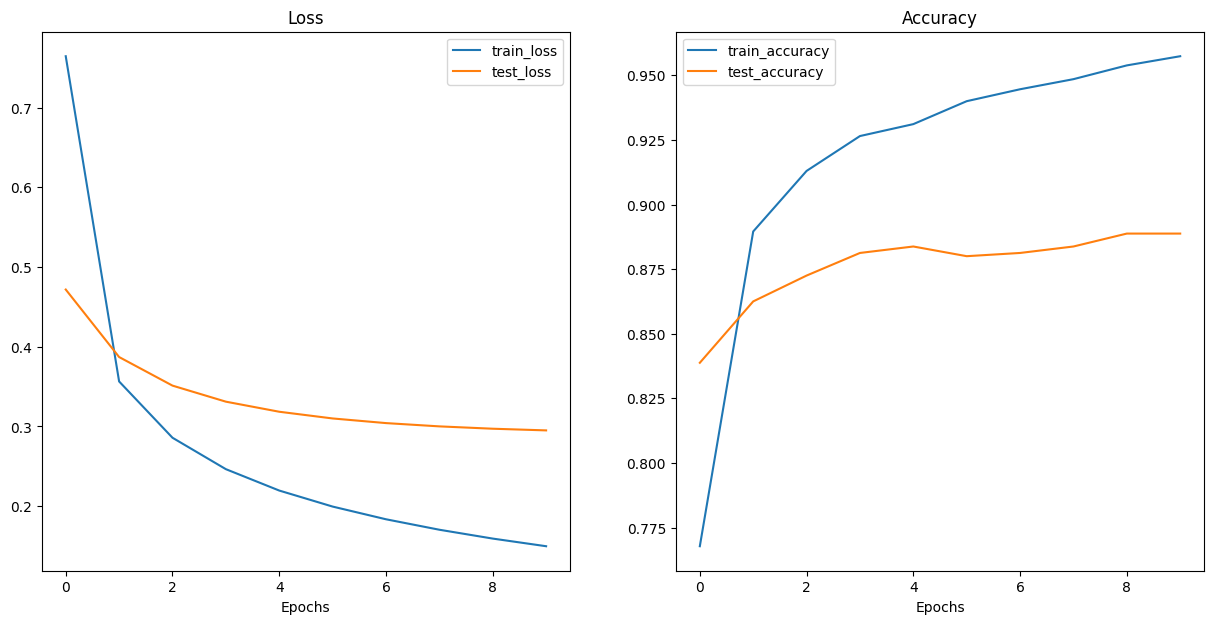

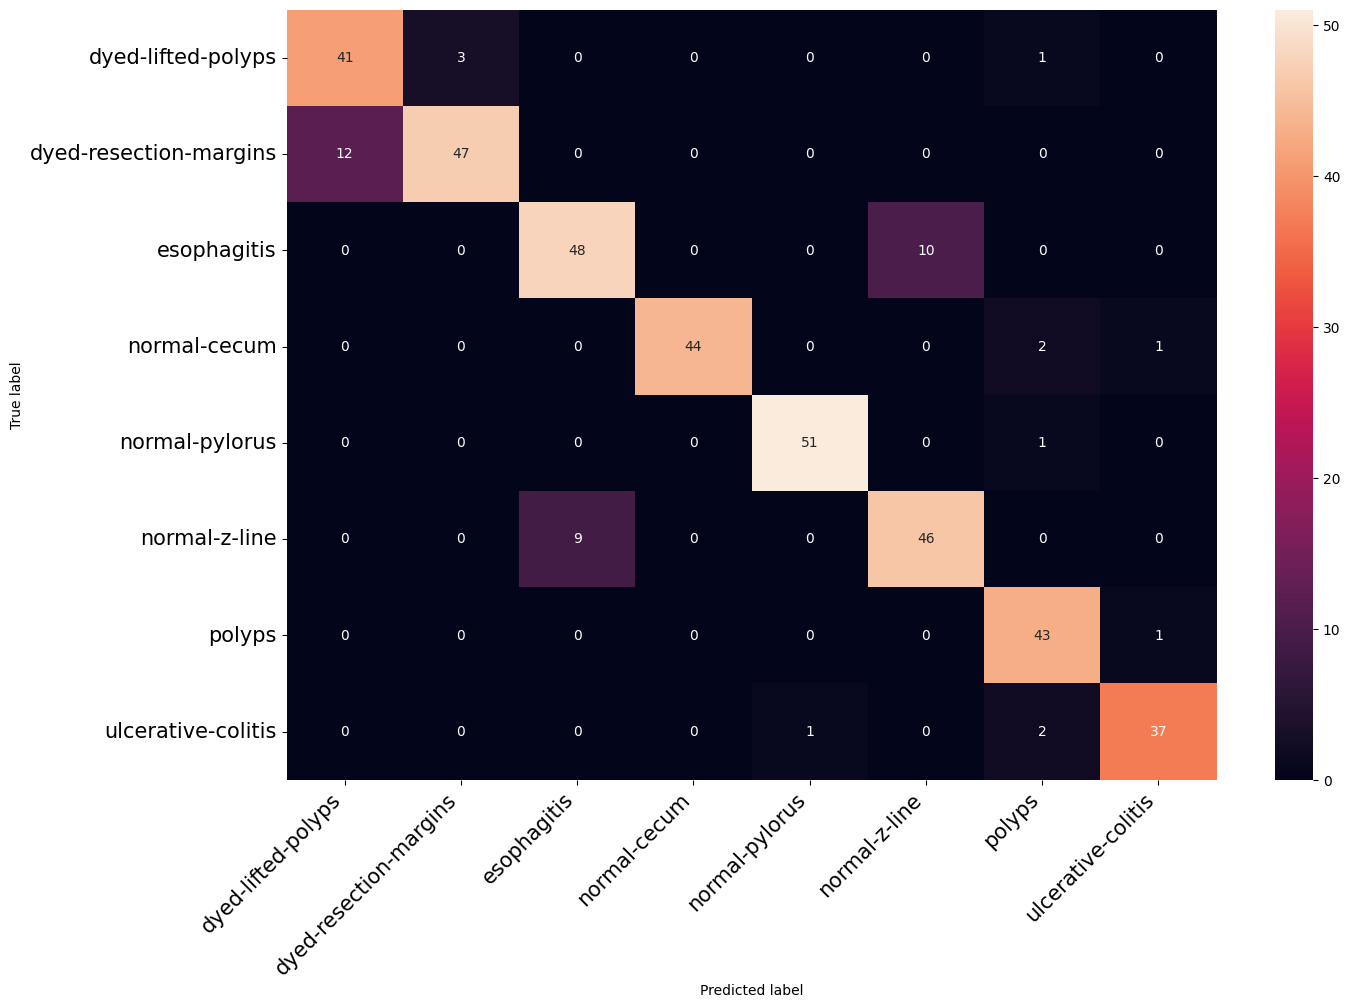

In [24]:
analysis(pretrained_vit, test_dataloader, "ViT", pretrained_vit_results)

del pretrained_vit
torch.cuda.empty_cache()
gc.collect()

Downloading: "https://download.pytorch.org/models/resnext101_64x4d-173b62eb.pth" to /root/.cache/torch/hub/checkpoints/resnext101_64x4d-173b62eb.pth
100%|██████████| 319M/319M [00:01<00:00, 284MB/s]


Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
ResNet (ResNet)                          [32, 3, 224, 224]    [32, 8]              --                   Partial
├─Conv2d (conv1)                         [32, 3, 224, 224]    [32, 64, 112, 112]   (9,408)              False
├─BatchNorm2d (bn1)                      [32, 64, 112, 112]   [32, 64, 112, 112]   (128)                False
├─ReLU (relu)                            [32, 64, 112, 112]   [32, 64, 112, 112]   --                   --
├─MaxPool2d (maxpool)                    [32, 64, 112, 112]   [32, 64, 56, 56]     --                   --
├─Sequential (layer1)                    [32, 64, 56, 56]     [32, 256, 56, 56]    --                   False
│    └─Bottleneck (0)                    [32, 64, 56, 56]     [32, 256, 56, 56]    --                   False
│    │    └─Conv2d (conv1)               [32, 64, 56, 56]     [32, 256, 56, 56]    (16,384)             False
│    │    

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0389 | train_acc: 0.6751 | test_loss: 0.5422 | test_acc: 0.8050
Epoch: 2 | train_loss: 0.4034 | train_acc: 0.8672 | test_loss: 0.4189 | test_acc: 0.8337
Epoch: 3 | train_loss: 0.2455 | train_acc: 0.9290 | test_loss: 0.3943 | test_acc: 0.8387
Epoch: 4 | train_loss: 0.1495 | train_acc: 0.9648 | test_loss: 0.4041 | test_acc: 0.8438
Epoch: 5 | train_loss: 0.0892 | train_acc: 0.9893 | test_loss: 0.4230 | test_acc: 0.8350
Epoch: 6 | train_loss: 0.0559 | train_acc: 0.9979 | test_loss: 0.4389 | test_acc: 0.8413
Epoch: 7 | train_loss: 0.0389 | train_acc: 0.9986 | test_loss: 0.4684 | test_acc: 0.8475
Epoch: 8 | train_loss: 0.0301 | train_acc: 0.9986 | test_loss: 0.4974 | test_acc: 0.8450
Epoch: 9 | train_loss: 0.0234 | train_acc: 0.9989 | test_loss: 0.5618 | test_acc: 0.8363
Epoch: 10 | train_loss: 0.0191 | train_acc: 0.9989 | test_loss: 0.5673 | test_acc: 0.8375
------------------------------
ResNexT
------------------------------


16996

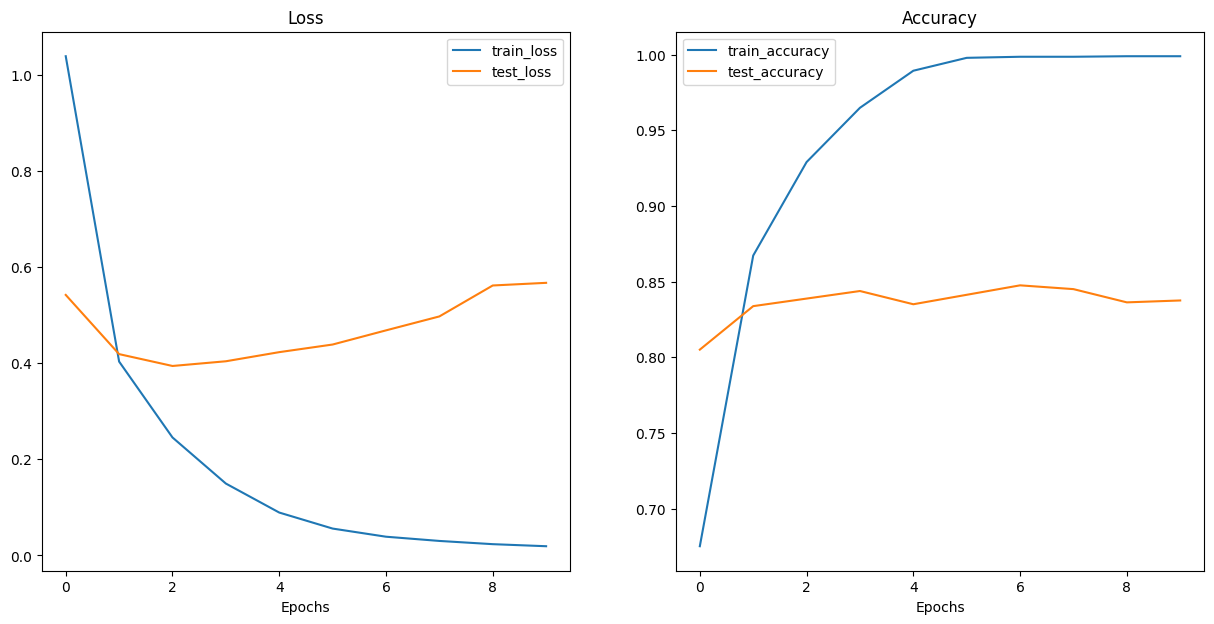

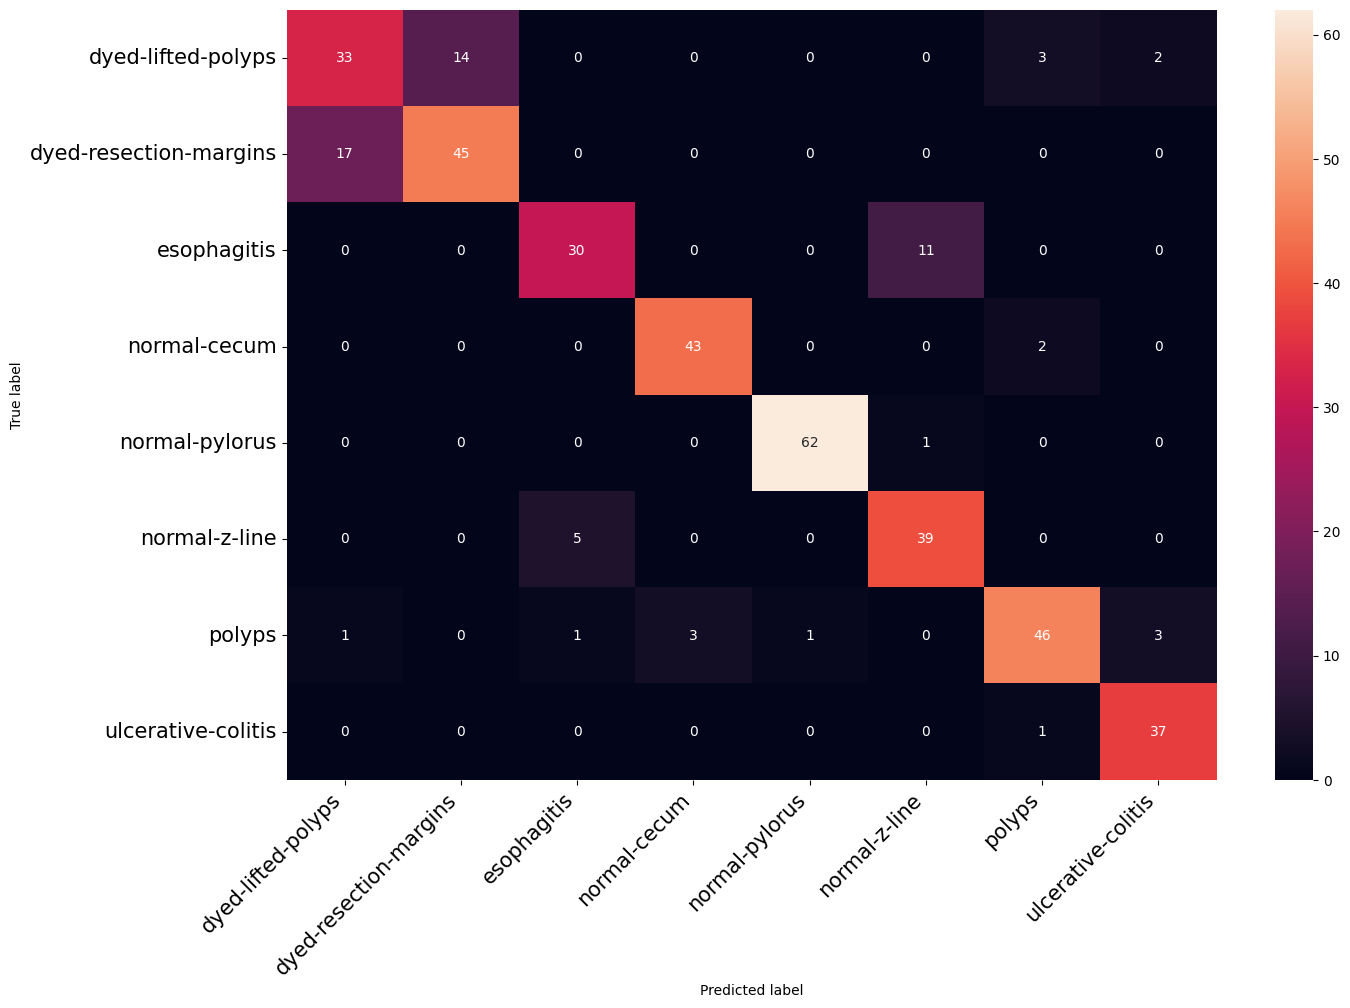

In [25]:
pretrained_weights = torchvision.models.ResNeXt101_64X4D_Weights.DEFAULT
pretrained_model = torchvision.models.resnext101_64x4d(weights=pretrained_weights).to(device)
for parameter in pretrained_model.parameters():
    parameter.requires_grad = False
set_seeds()
pretrained_model.fc = nn.Sequential(
    nn.Linear(in_features=2048, out_features=128),
    nn.Linear(in_features=128, out_features=len(class_names))
).to(device)

#pretrained_model.fc = nn.Linear(in_features=2048, out_features=len(class_names)).to(device)

print(summary(model=pretrained_model, 
        input_size=(32, 3, 224, 224), # (batch_size, color_channels, height, width)
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
))

Batch_Size = 32
pretrained_transforms = pretrained_weights.transforms()

new_transforms= transforms.Compose([
    pretrained_transforms
])

val_transforms = transforms.Compose([
    pretrained_transforms
])

train_dataloader, val_dataloader, test_dataloader, class_names = create_dataloaders(
    indir = indir, 
    transform = new_transforms,
    val_transform = val_transforms,
    batch_size = Batch_Size,
    num_workers = NUM_WORKERS
)

optimizer = torch.optim.Adam(params=pretrained_model.parameters(), 
                             lr=1e-3)
loss_fn = torch.nn.CrossEntropyLoss()

set_seeds()
pretrained_results = train(model=pretrained_model,
                                      train_dataloader=train_dataloader,
                                      test_dataloader=val_dataloader,
                                      optimizer=optimizer,
                                      loss_fn=loss_fn,
                                      epochs=10,
                                      device=device)

analysis(pretrained_model, test_dataloader, "ResNexT", pretrained_results)

del pretrained_model
torch.cuda.empty_cache()
gc.collect()

Downloading: "https://download.pytorch.org/models/regnet_y_8gf-dc2b1b54.pth" to /root/.cache/torch/hub/checkpoints/regnet_y_8gf-dc2b1b54.pth
100%|██████████| 151M/151M [00:00<00:00, 290MB/s]


Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
RegNet (RegNet)                                              [32, 3, 224, 224]    [32, 8]              --                   Partial
├─SimpleStemIN (stem)                                        [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    └─Conv2d (0)                                            [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    └─BatchNorm2d (1)                                       [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    └─ReLU (2)                                              [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
├─Sequential (trunk_output)                                  [32, 32, 112, 112]   [32, 2016, 7, 7]     --                   False
│    └─AnyStage (block1)                                     [32, 32, 112, 112]   [32, 

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.8030 | train_acc: 0.7113 | test_loss: 0.4784 | test_acc: 0.8200
Epoch: 2 | train_loss: 0.3398 | train_acc: 0.8810 | test_loss: 0.4153 | test_acc: 0.8438
Epoch: 3 | train_loss: 0.2244 | train_acc: 0.9254 | test_loss: 0.3998 | test_acc: 0.8438
Epoch: 4 | train_loss: 0.1589 | train_acc: 0.9528 | test_loss: 0.4124 | test_acc: 0.8475
Epoch: 5 | train_loss: 0.1169 | train_acc: 0.9716 | test_loss: 0.4617 | test_acc: 0.8363
Epoch: 6 | train_loss: 0.0933 | train_acc: 0.9741 | test_loss: 0.5499 | test_acc: 0.8225
Epoch: 7 | train_loss: 0.0783 | train_acc: 0.9776 | test_loss: 0.5210 | test_acc: 0.8488
Epoch: 8 | train_loss: 0.0850 | train_acc: 0.9719 | test_loss: 0.5825 | test_acc: 0.8438
Epoch: 9 | train_loss: 0.1085 | train_acc: 0.9553 | test_loss: 0.8893 | test_acc: 0.7837
Epoch: 10 | train_loss: 0.1468 | train_acc: 0.9556 | test_loss: 0.5840 | test_acc: 0.8387
------------------------------
RegNeT
------------------------------


16997

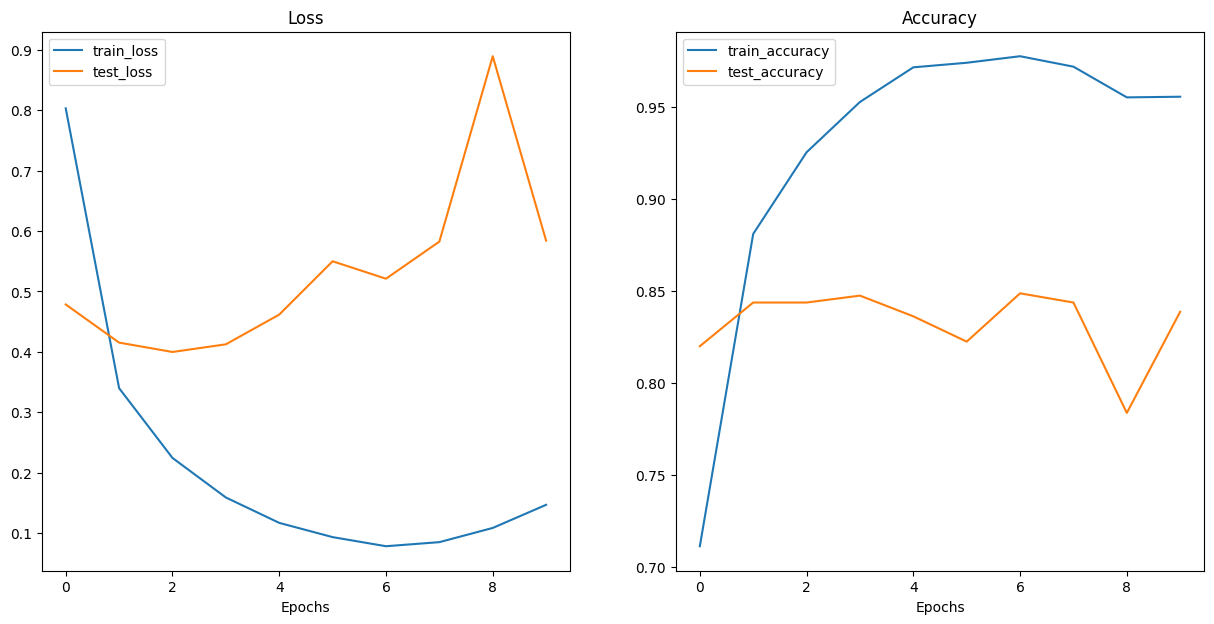

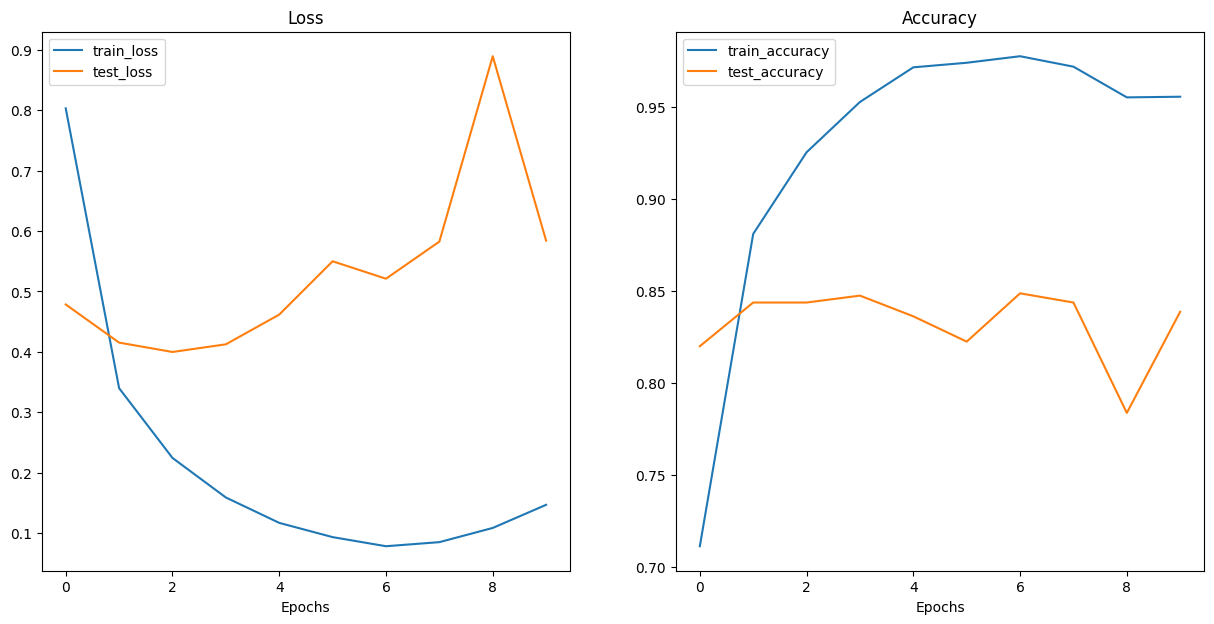

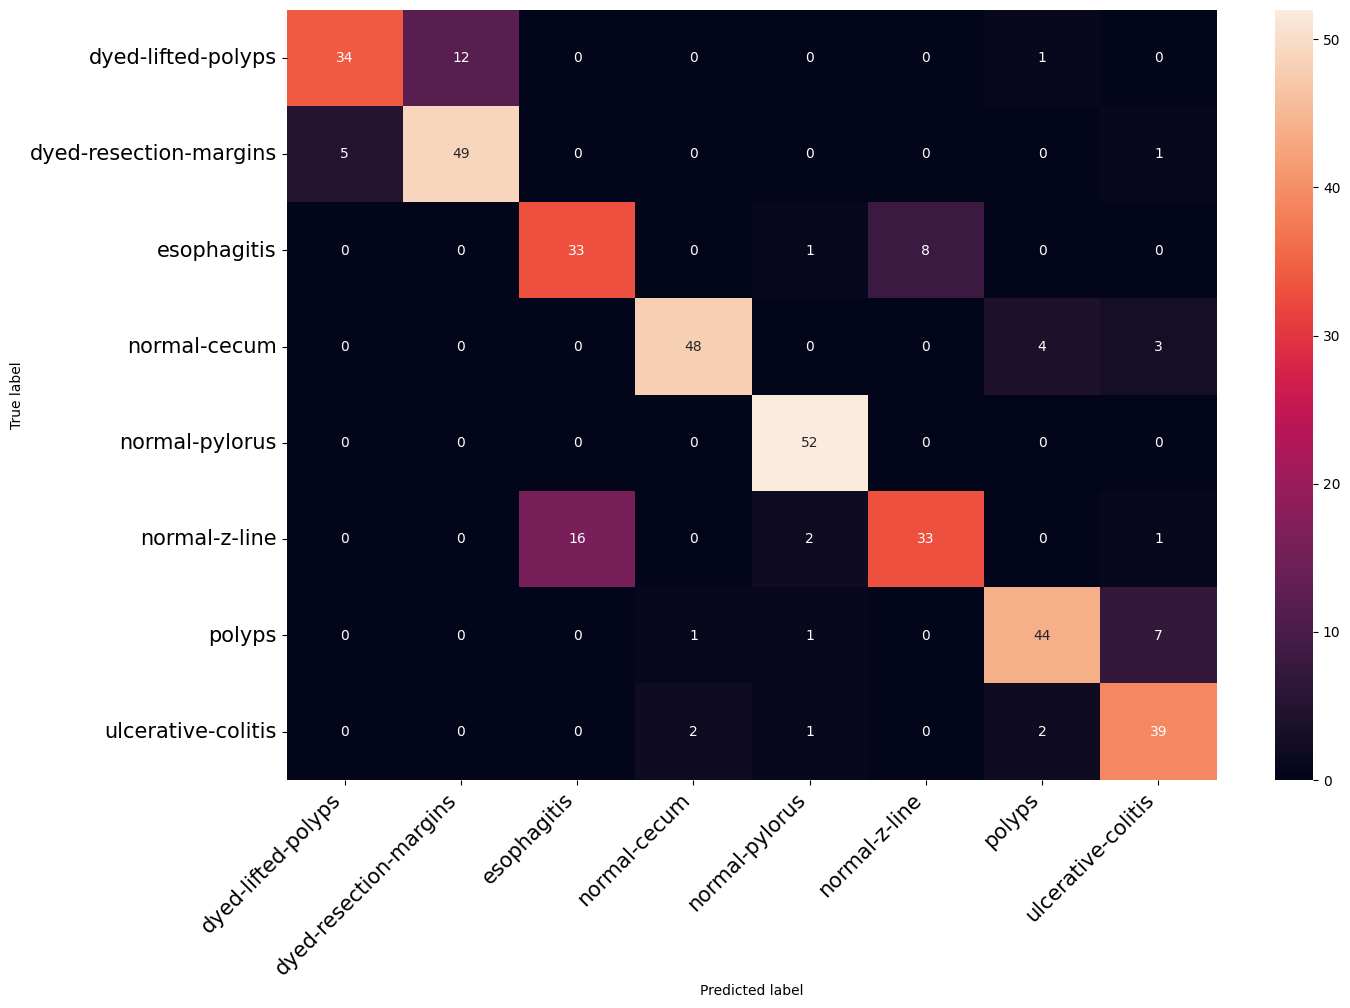

In [26]:
pretrained_weights = torchvision.models.RegNet_Y_8GF_Weights.DEFAULT
pretrained_model = torchvision.models.regnet_y_8gf(weights=pretrained_weights).to(device)
for parameter in pretrained_model.parameters():
    parameter.requires_grad = False
set_seeds()

pretrained_model.fc = nn.Sequential(
    nn.Linear(in_features=2016, out_features=128),
    nn.Linear(in_features=128, out_features=len(class_names))
).to(device)

#pretrained_model.fc = nn.Linear(in_features=2048, out_features=len(class_names)).to(device)

print(summary(model=pretrained_model, 
        input_size=(32, 3, 224, 224), # (batch_size, color_channels, height, width)
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
))

Batch_Size = 32
pretrained_transforms = pretrained_weights.transforms()

new_transforms= transforms.Compose([
    pretrained_transforms
])

val_transforms = transforms.Compose([
    pretrained_transforms
])

train_dataloader, val_dataloader, test_dataloader, class_names = create_dataloaders(
    indir = indir, 
    transform = new_transforms,
    val_transform = val_transforms,
    batch_size = Batch_Size,
    num_workers = NUM_WORKERS
)

optimizer = torch.optim.Adam(params=pretrained_model.parameters(), 
                             lr=1e-3)
loss_fn = torch.nn.CrossEntropyLoss()

set_seeds()
pretrained_results = train(model=pretrained_model,
                                      train_dataloader=train_dataloader,
                                      test_dataloader=val_dataloader,
                                      optimizer=optimizer,
                                      loss_fn=loss_fn,
                                      epochs=10,
                                      device=device)

plot_loss_curves(pretrained_results)

for parameter in pretrained_model.parameters():
    parameter.requires_grad = True

optimizer = torch.optim.Adam(params=pretrained_model.parameters(), 
                             lr=1e-5)

set_seeds()

analysis(pretrained_model, test_dataloader, "RegNeT", pretrained_results)

del pretrained_model
torch.cuda.empty_cache()
gc.collect()

Downloading: "https://download.pytorch.org/models/regnet_y_32gf-8db6d4b5.pth" to /root/.cache/torch/hub/checkpoints/regnet_y_32gf-8db6d4b5.pth
100%|██████████| 554M/554M [00:01<00:00, 295MB/s]


Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
RegNet (RegNet)                                              [32, 3, 224, 224]    [32, 1000]           --                   False
├─SimpleStemIN (stem)                                        [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    └─Conv2d (0)                                            [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    └─BatchNorm2d (1)                                       [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    └─ReLU (2)                                              [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
├─Sequential (trunk_output)                                  [32, 32, 112, 112]   [32, 3712, 7, 7]     --                   False
│    └─AnyStage (block1)                                     [32, 32, 112, 112]   [32, 23

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.7519 | train_acc: 0.7244 | test_loss: 0.4718 | test_acc: 0.8137
Epoch: 2 | train_loss: 0.2937 | train_acc: 0.8945 | test_loss: 0.4397 | test_acc: 0.8375
Epoch: 3 | train_loss: 0.1796 | train_acc: 0.9467 | test_loss: 0.4649 | test_acc: 0.8425
Epoch: 4 | train_loss: 0.1184 | train_acc: 0.9673 | test_loss: 0.5120 | test_acc: 0.8450
Epoch: 5 | train_loss: 0.0935 | train_acc: 0.9727 | test_loss: 0.6833 | test_acc: 0.8175
Epoch: 6 | train_loss: 0.1099 | train_acc: 0.9585 | test_loss: 0.7844 | test_acc: 0.8163
Epoch: 7 | train_loss: 0.1182 | train_acc: 0.9496 | test_loss: 0.7707 | test_acc: 0.8263
Epoch: 8 | train_loss: 0.1674 | train_acc: 0.9389 | test_loss: 0.6409 | test_acc: 0.8400
Epoch: 9 | train_loss: 0.1414 | train_acc: 0.9545 | test_loss: 0.4558 | test_acc: 0.8550
Epoch: 10 | train_loss: 0.0863 | train_acc: 0.9677 | test_loss: 0.4724 | test_acc: 0.8450
------------------------------
RegNet 2
------------------------------


24357

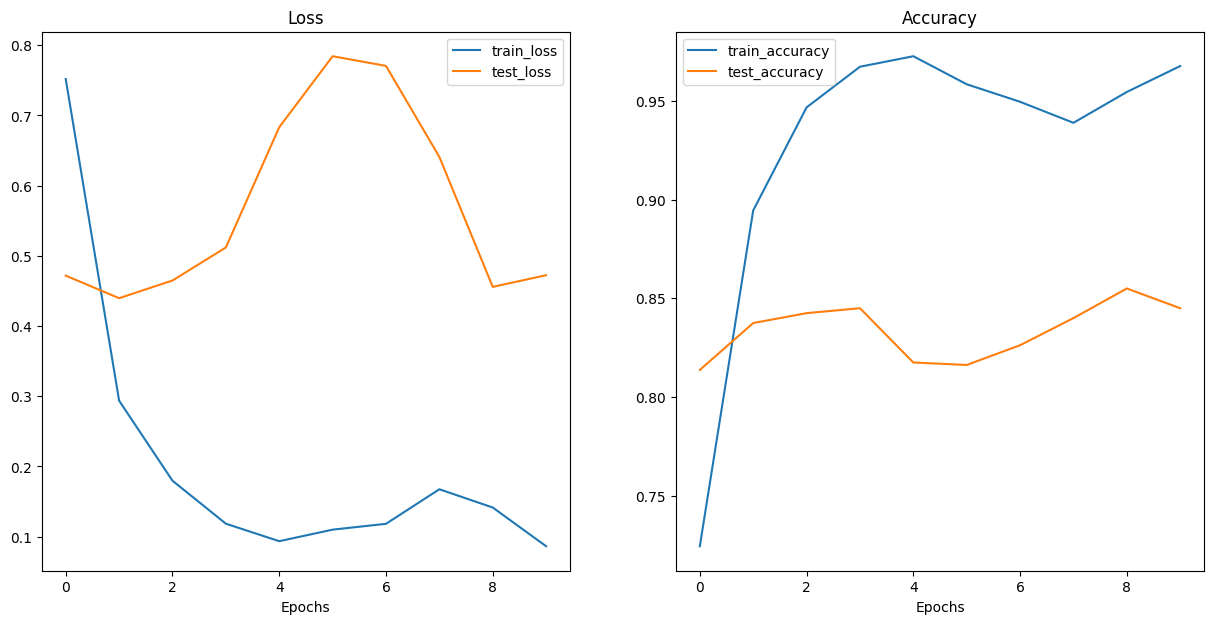

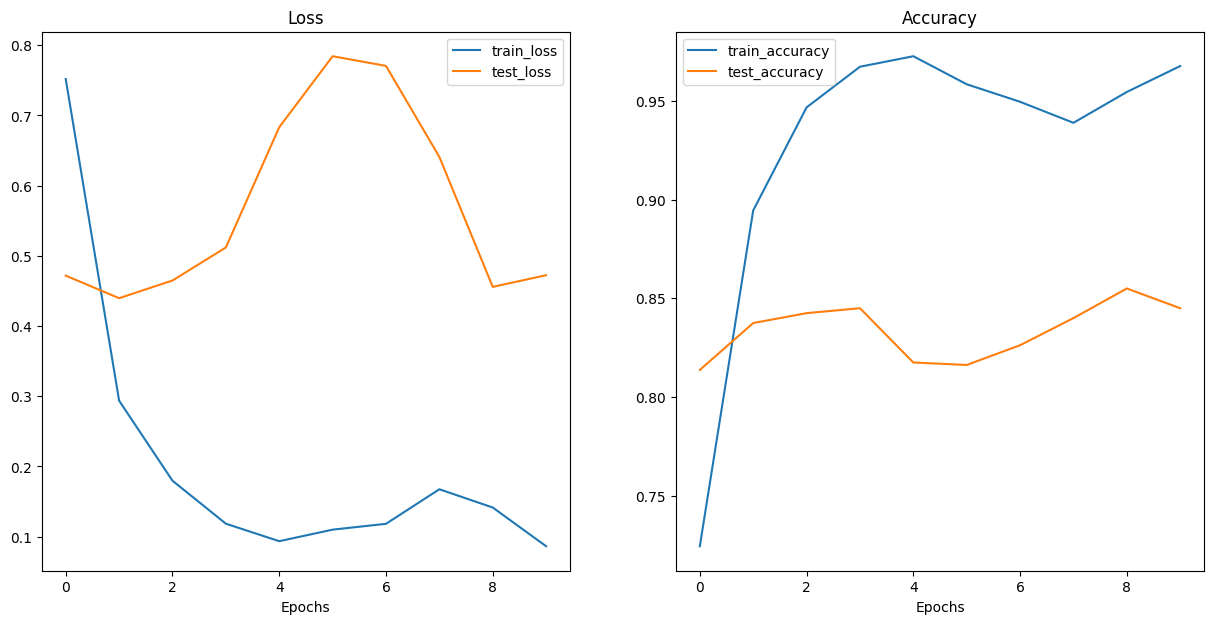

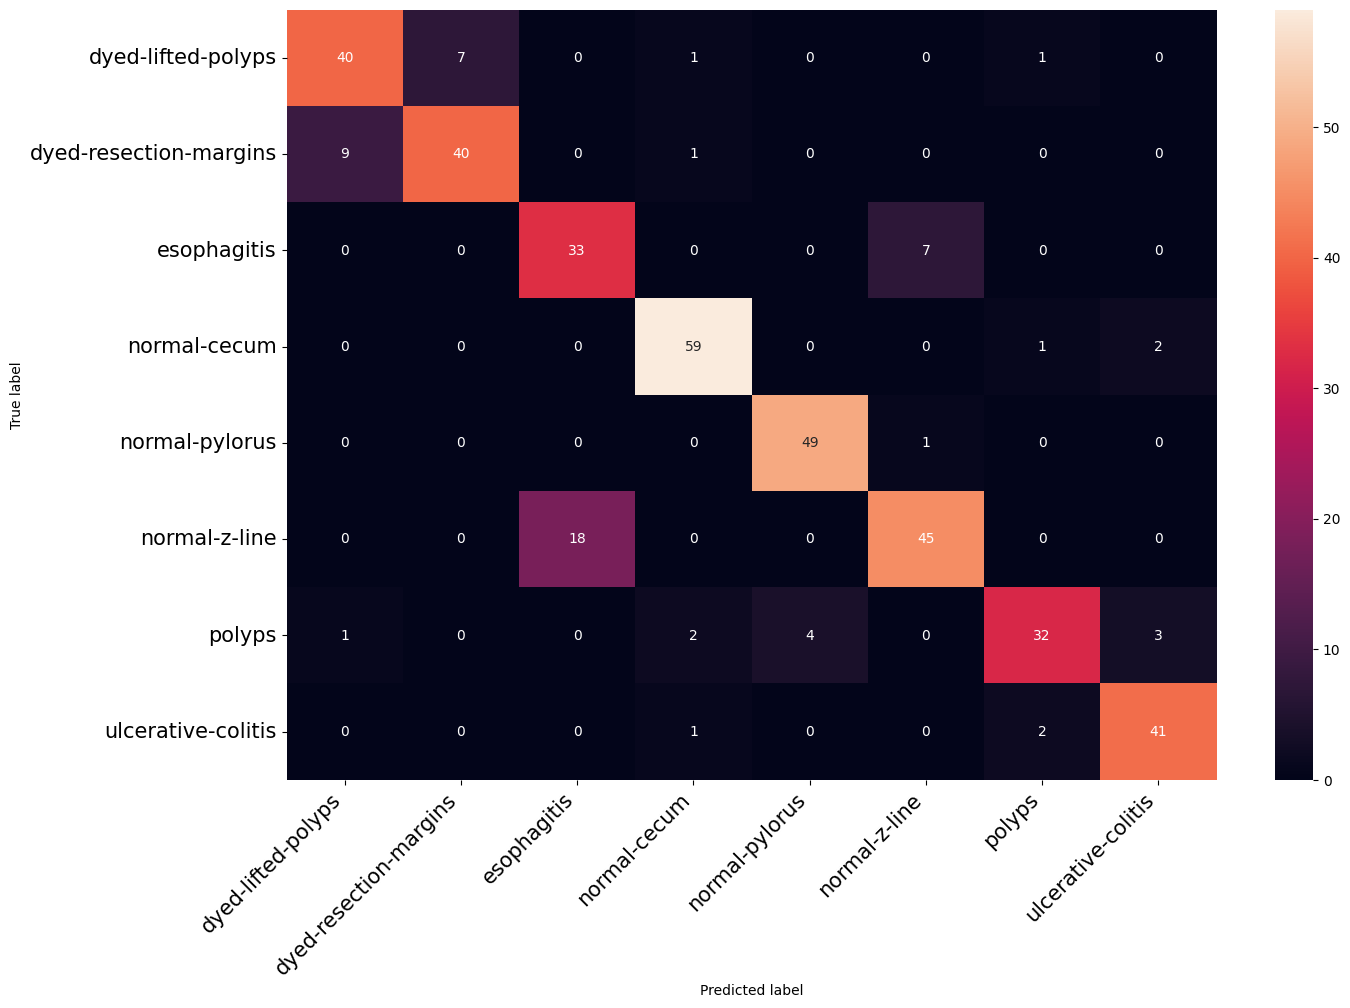

In [27]:
pretrained_weights = torchvision.models.RegNet_Y_32GF_Weights.DEFAULT
pretrained_model = torchvision.models.regnet_y_32gf(weights=pretrained_weights).to(device)
for parameter in pretrained_model.parameters():
    parameter.requires_grad = False
set_seeds()

print(summary(model=pretrained_model, 
        input_size=(32, 3, 224, 224), # (batch_size, color_channels, height, width)
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
))

pretrained_model.fc = nn.Sequential(
    nn.Linear(in_features=3712, out_features=128),
    nn.Linear(in_features=128, out_features=len(class_names))
).to(device)

#pretrained_model.fc = nn.Linear(in_features=2048, out_features=len(class_names)).to(device)

print(summary(model=pretrained_model, 
        input_size=(32, 3, 224, 224), # (batch_size, color_channels, height, width)
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
))

Batch_Size = 32
pretrained_transforms = pretrained_weights.transforms()

new_transforms= transforms.Compose([
    pretrained_transforms
])

val_transforms = transforms.Compose([
    pretrained_transforms
])

train_dataloader, val_dataloader, test_dataloader, class_names = create_dataloaders(
    indir = indir, 
    transform = new_transforms,
    val_transform = val_transforms,
    batch_size = Batch_Size,
    num_workers = NUM_WORKERS
)

optimizer = torch.optim.Adam(params=pretrained_model.parameters(), 
                             lr=1e-3)
loss_fn = torch.nn.CrossEntropyLoss()

set_seeds()
pretrained_results = train(model=pretrained_model,
                                      train_dataloader=train_dataloader,
                                      test_dataloader=val_dataloader,
                                      optimizer=optimizer,
                                      loss_fn=loss_fn,
                                      epochs=10,
                                      device=device)


plot_loss_curves(pretrained_results)

for parameter in pretrained_model.parameters():
    parameter.requires_grad = True

optimizer = torch.optim.Adam(params=pretrained_model.parameters(), 
                             lr=1e-5)

set_seeds()
analysis(pretrained_model, test_dataloader, "RegNet 2", pretrained_results)

del pretrained_model
torch.cuda.empty_cache()
gc.collect()

Downloading: "https://download.pytorch.org/models/efficientnet_v2_s-dd5fe13b.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_v2_s-dd5fe13b.pth
100%|██████████| 82.7M/82.7M [00:00<00:00, 281MB/s]


Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 1000]           --                   False
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 24, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 24, 112, 112]   (648)                False
│    │    └─BatchNorm2d (1)                                  [32, 24, 112, 112]   [32, 24, 112, 112]   (48)                 False
│    │    └─SiLU (2)                                         [32, 24, 112, 112]   [32, 24, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 24, 112, 112]   [32, 24

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9444 | train_acc: 0.6836 | test_loss: 0.5263 | test_acc: 0.8013
Epoch: 2 | train_loss: 0.4881 | train_acc: 0.8221 | test_loss: 0.4399 | test_acc: 0.8263
Epoch: 3 | train_loss: 0.4135 | train_acc: 0.8462 | test_loss: 0.4140 | test_acc: 0.8313
Epoch: 4 | train_loss: 0.3646 | train_acc: 0.8608 | test_loss: 0.4275 | test_acc: 0.8350
Epoch: 5 | train_loss: 0.3282 | train_acc: 0.8690 | test_loss: 0.4432 | test_acc: 0.8287
Epoch: 6 | train_loss: 0.3165 | train_acc: 0.8817 | test_loss: 0.4252 | test_acc: 0.8413
Epoch: 7 | train_loss: 0.2979 | train_acc: 0.8853 | test_loss: 0.4218 | test_acc: 0.8488
Epoch: 8 | train_loss: 0.2884 | train_acc: 0.8906 | test_loss: 0.4377 | test_acc: 0.8325
Epoch: 9 | train_loss: 0.2709 | train_acc: 0.9009 | test_loss: 0.4711 | test_acc: 0.8163
Epoch: 10 | train_loss: 0.2600 | train_acc: 0.9006 | test_loss: 0.4525 | test_acc: 0.8363
------------------------------
EfficientNet
------------------------------


24019

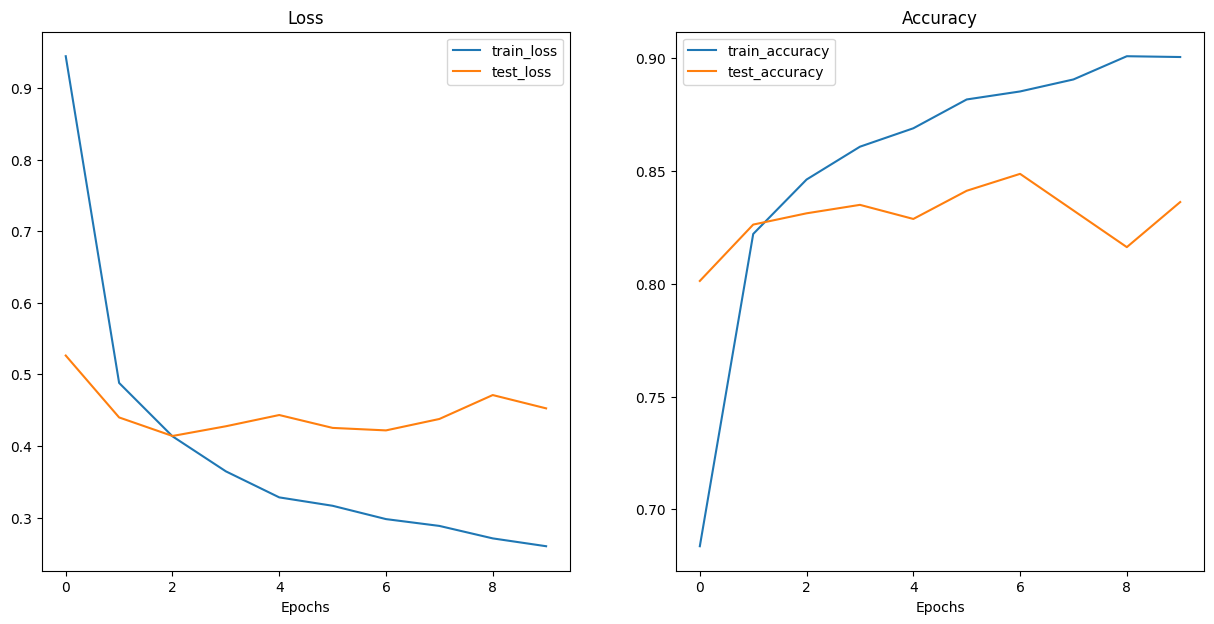

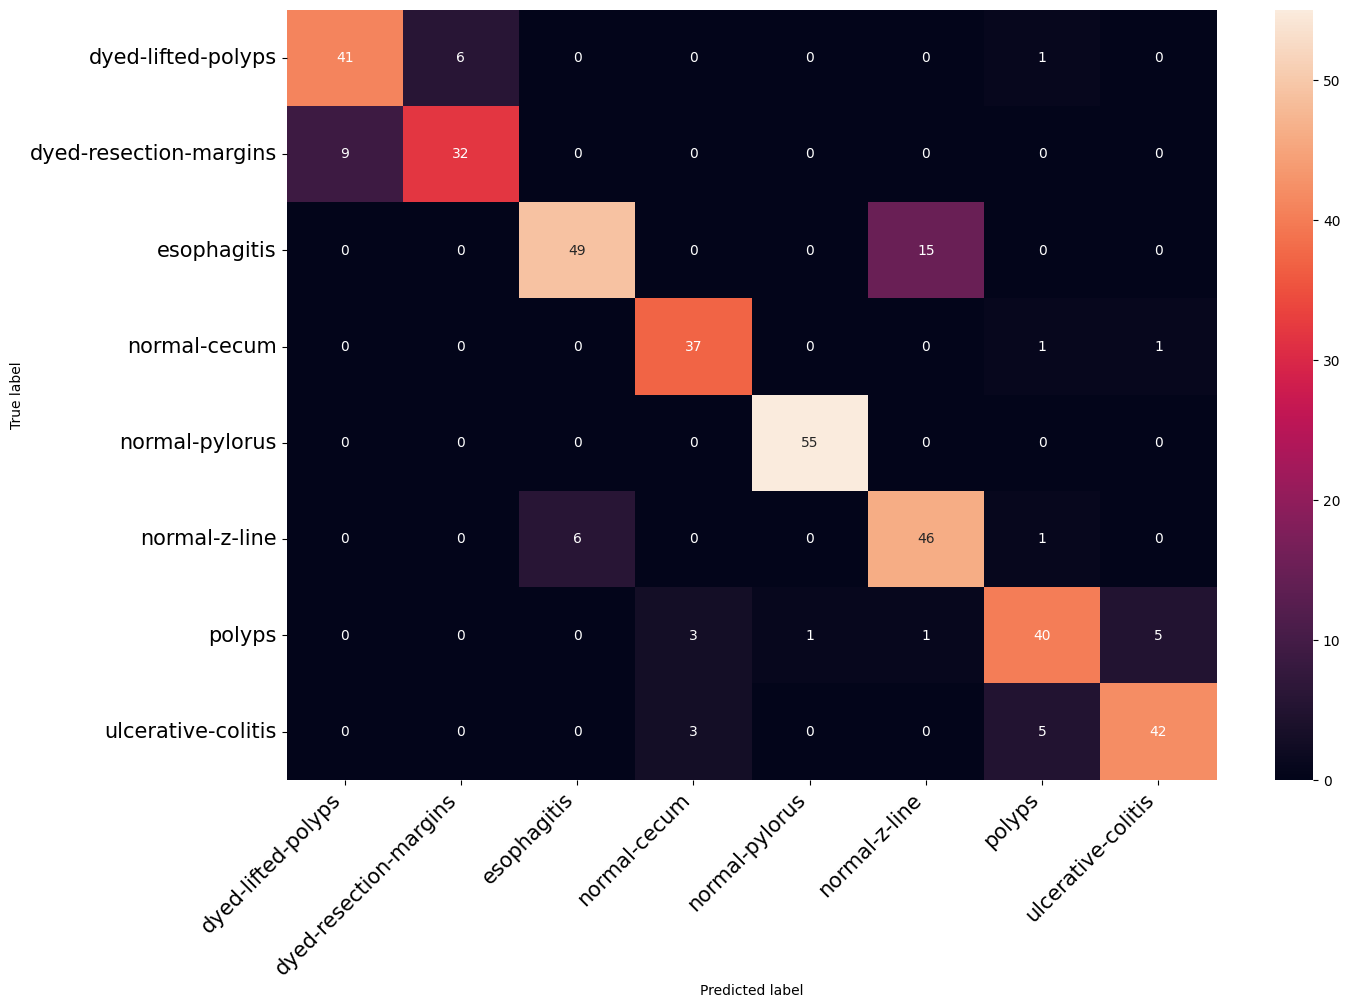

In [28]:
pretrained_weights = torchvision.models.EfficientNet_V2_S_Weights.DEFAULT
pretrained_model = torchvision.models.efficientnet_v2_s(weights=pretrained_weights).to(device)
for parameter in pretrained_model.parameters():
    parameter.requires_grad = False
set_seeds()

print(summary(model=pretrained_model, 
        input_size=(32, 3, 224, 224), # (batch_size, color_channels, height, width)
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
))

pretrained_model.classifier = nn.Sequential(
    nn.Linear(in_features=1280, out_features=128),
    nn.Linear(in_features=128, out_features=len(class_names))
).to(device)

#pretrained_model.fc = nn.Linear(in_features=2048, out_features=len(class_names)).to(device)

print(summary(model=pretrained_model, 
        input_size=(32, 3, 224, 224), # (batch_size, color_channels, height, width)
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
))

Batch_Size = 32
pretrained_transforms = pretrained_weights.transforms()

new_transforms= transforms.Compose([
    pretrained_transforms
])

val_transforms = transforms.Compose([
    pretrained_transforms
])

train_dataloader, val_dataloader, test_dataloader, class_names = create_dataloaders(
    indir = indir, 
    transform = new_transforms,
    val_transform = val_transforms,
    batch_size = Batch_Size,
    num_workers = NUM_WORKERS
)

optimizer = torch.optim.Adam(params=pretrained_model.parameters(), 
                             lr=1e-3)
loss_fn = torch.nn.CrossEntropyLoss()

set_seeds()
pretrained_results = train(model=pretrained_model,
                                      train_dataloader=train_dataloader,
                                      test_dataloader=val_dataloader,
                                      optimizer=optimizer,
                                      loss_fn=loss_fn,
                                      epochs=10,
                                      device=device)

analysis(pretrained_model, test_dataloader, "EfficientNet", pretrained_results)


del pretrained_model
torch.cuda.empty_cache()
gc.collect()